## Imports

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import praw 
import pandas_profiling

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from nltk.probability import FreqDist
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
from PIL import Image 

from bs4 import BeautifulSoup
from wordcloud import WordCloud

%matplotlib inline


C:\Users\marta.nawrocka\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import sys
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\marta.nawrocka\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
df = pd.read_csv('data/BA_reviews.csv')

In [5]:
df.head()

,Unnamed: 0,reviews
0,0,✅ Trip Verified | They downgraded me from bu...
1,1,✅ Trip Verified | The already delayed aircra...
2,2,✅ Trip Verified | Caught up in the Gatwick c...
3,3,✅ Trip Verified | BA has a real problem with...
4,4,✅ Trip Verified | Our connecting flight from L...


In [6]:
df.reviews = df.reviews.str.split('|', expand=True)[1]

In [7]:
df.head()

,Unnamed: 0,reviews
0,0,They downgraded me from business to premium...
1,1,The already delayed aircraft landed and apa...
2,2,Caught up in the Gatwick cancellation fiasc...
3,3,BA has a real problem with boarding it's fl...
4,4,Our connecting flight from London to Glasgow ...


In [8]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marta.nawrocka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marta.nawrocka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marta.nawrocka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
stop_words = set(stopwords.words('english'))

def text_cleaning(text):
    words = word_tokenize(text.lower())
    clean_words = []
    lemmatizer  = WordNetLemmatizer()
    for word in words:
        if word not in stop_words and word.isalpha():
            clean_words.append(lemmatizer.lemmatize(word))
    return " ".join(clean_words)

In [10]:
df.reviews = df.reviews.apply(text_cleaning)

In [11]:
from collections import Counter 
splitted_reviews = (" ".join(df.reviews).split())
Counter = Counter(splitted_reviews)
freq_words = Counter.most_common(20)

In [12]:
freq_words

[('flight', 2140),
 ('ba', 1160),
 ('seat', 901),
 ('service', 740),
 ('time', 606),
 ('london', 571),
 ('hour', 551),
 ('crew', 449),
 ('food', 447),
 ('airline', 436),
 ('one', 432),
 ('class', 429),
 ('british', 416),
 ('airway', 415),
 ('staff', 409),
 ('good', 409),
 ('would', 399),
 ('u', 394),
 ('cabin', 383),
 ('business', 380)]

In [13]:
from nltk.util import ngrams
from collections import Counter

review_word_list = [''.join(word) for word in df.reviews]
reviews_as_string  = ' '.join(review_word_list)

n_gram =2 
n_gram_dict = dict(Counter(ngrams(reviews_as_string.split(), n_gram)))

for i in n_gram_dict:
    if n_gram_dict[i]>=50:
        print(i, n_gram_dict[i])

('premium', 'economy') 74
('business', 'class') 286
('flight', 'cancelled') 61
('even', 'though') 50
('connecting', 'flight') 84
('flight', 'london') 53
('cabin', 'crew') 172
('british', 'airway') 402
('return', 'flight') 80
('club', 'europe') 53
('hour', 'flight') 66
('customer', 'service') 192
('flight', 'delayed') 57
('via', 'london') 66
('london', 'heathrow') 99
('club', 'world') 63


In [14]:
from nltk.util import ngrams
from collections import Counter

review_word_list = [''.join(word) for word in df.reviews]
reviews_as_string  = ' '.join(review_word_list)

n_gram =3 
n_gram_dict = dict(Counter(ngrams(reviews_as_string.split(), n_gram)))

for i in n_gram_dict:
    if n_gram_dict[i]>=10:
        print(i, n_gram_dict[i])

('ba', 'business', 'class') 12
('business', 'class', 'seat') 28
('never', 'fly', 'ba') 11
('business', 'class', 'passenger') 15
('fly', 'british', 'airway') 17
('missed', 'connecting', 'flight') 15
('london', 'british', 'airway') 11
('british', 'airway', 'flight') 13
('business', 'class', 'ticket') 16
('new', 'club', 'suite') 12
('experience', 'british', 'airway') 12
('flight', 'delayed', 'hour') 11
('ba', 'customer', 'service') 20
('flight', 'british', 'airway') 14
('flight', 'left', 'time') 10
('long', 'haul', 'flight') 11
('short', 'haul', 'flight') 10
('new', 'club', 'world') 11


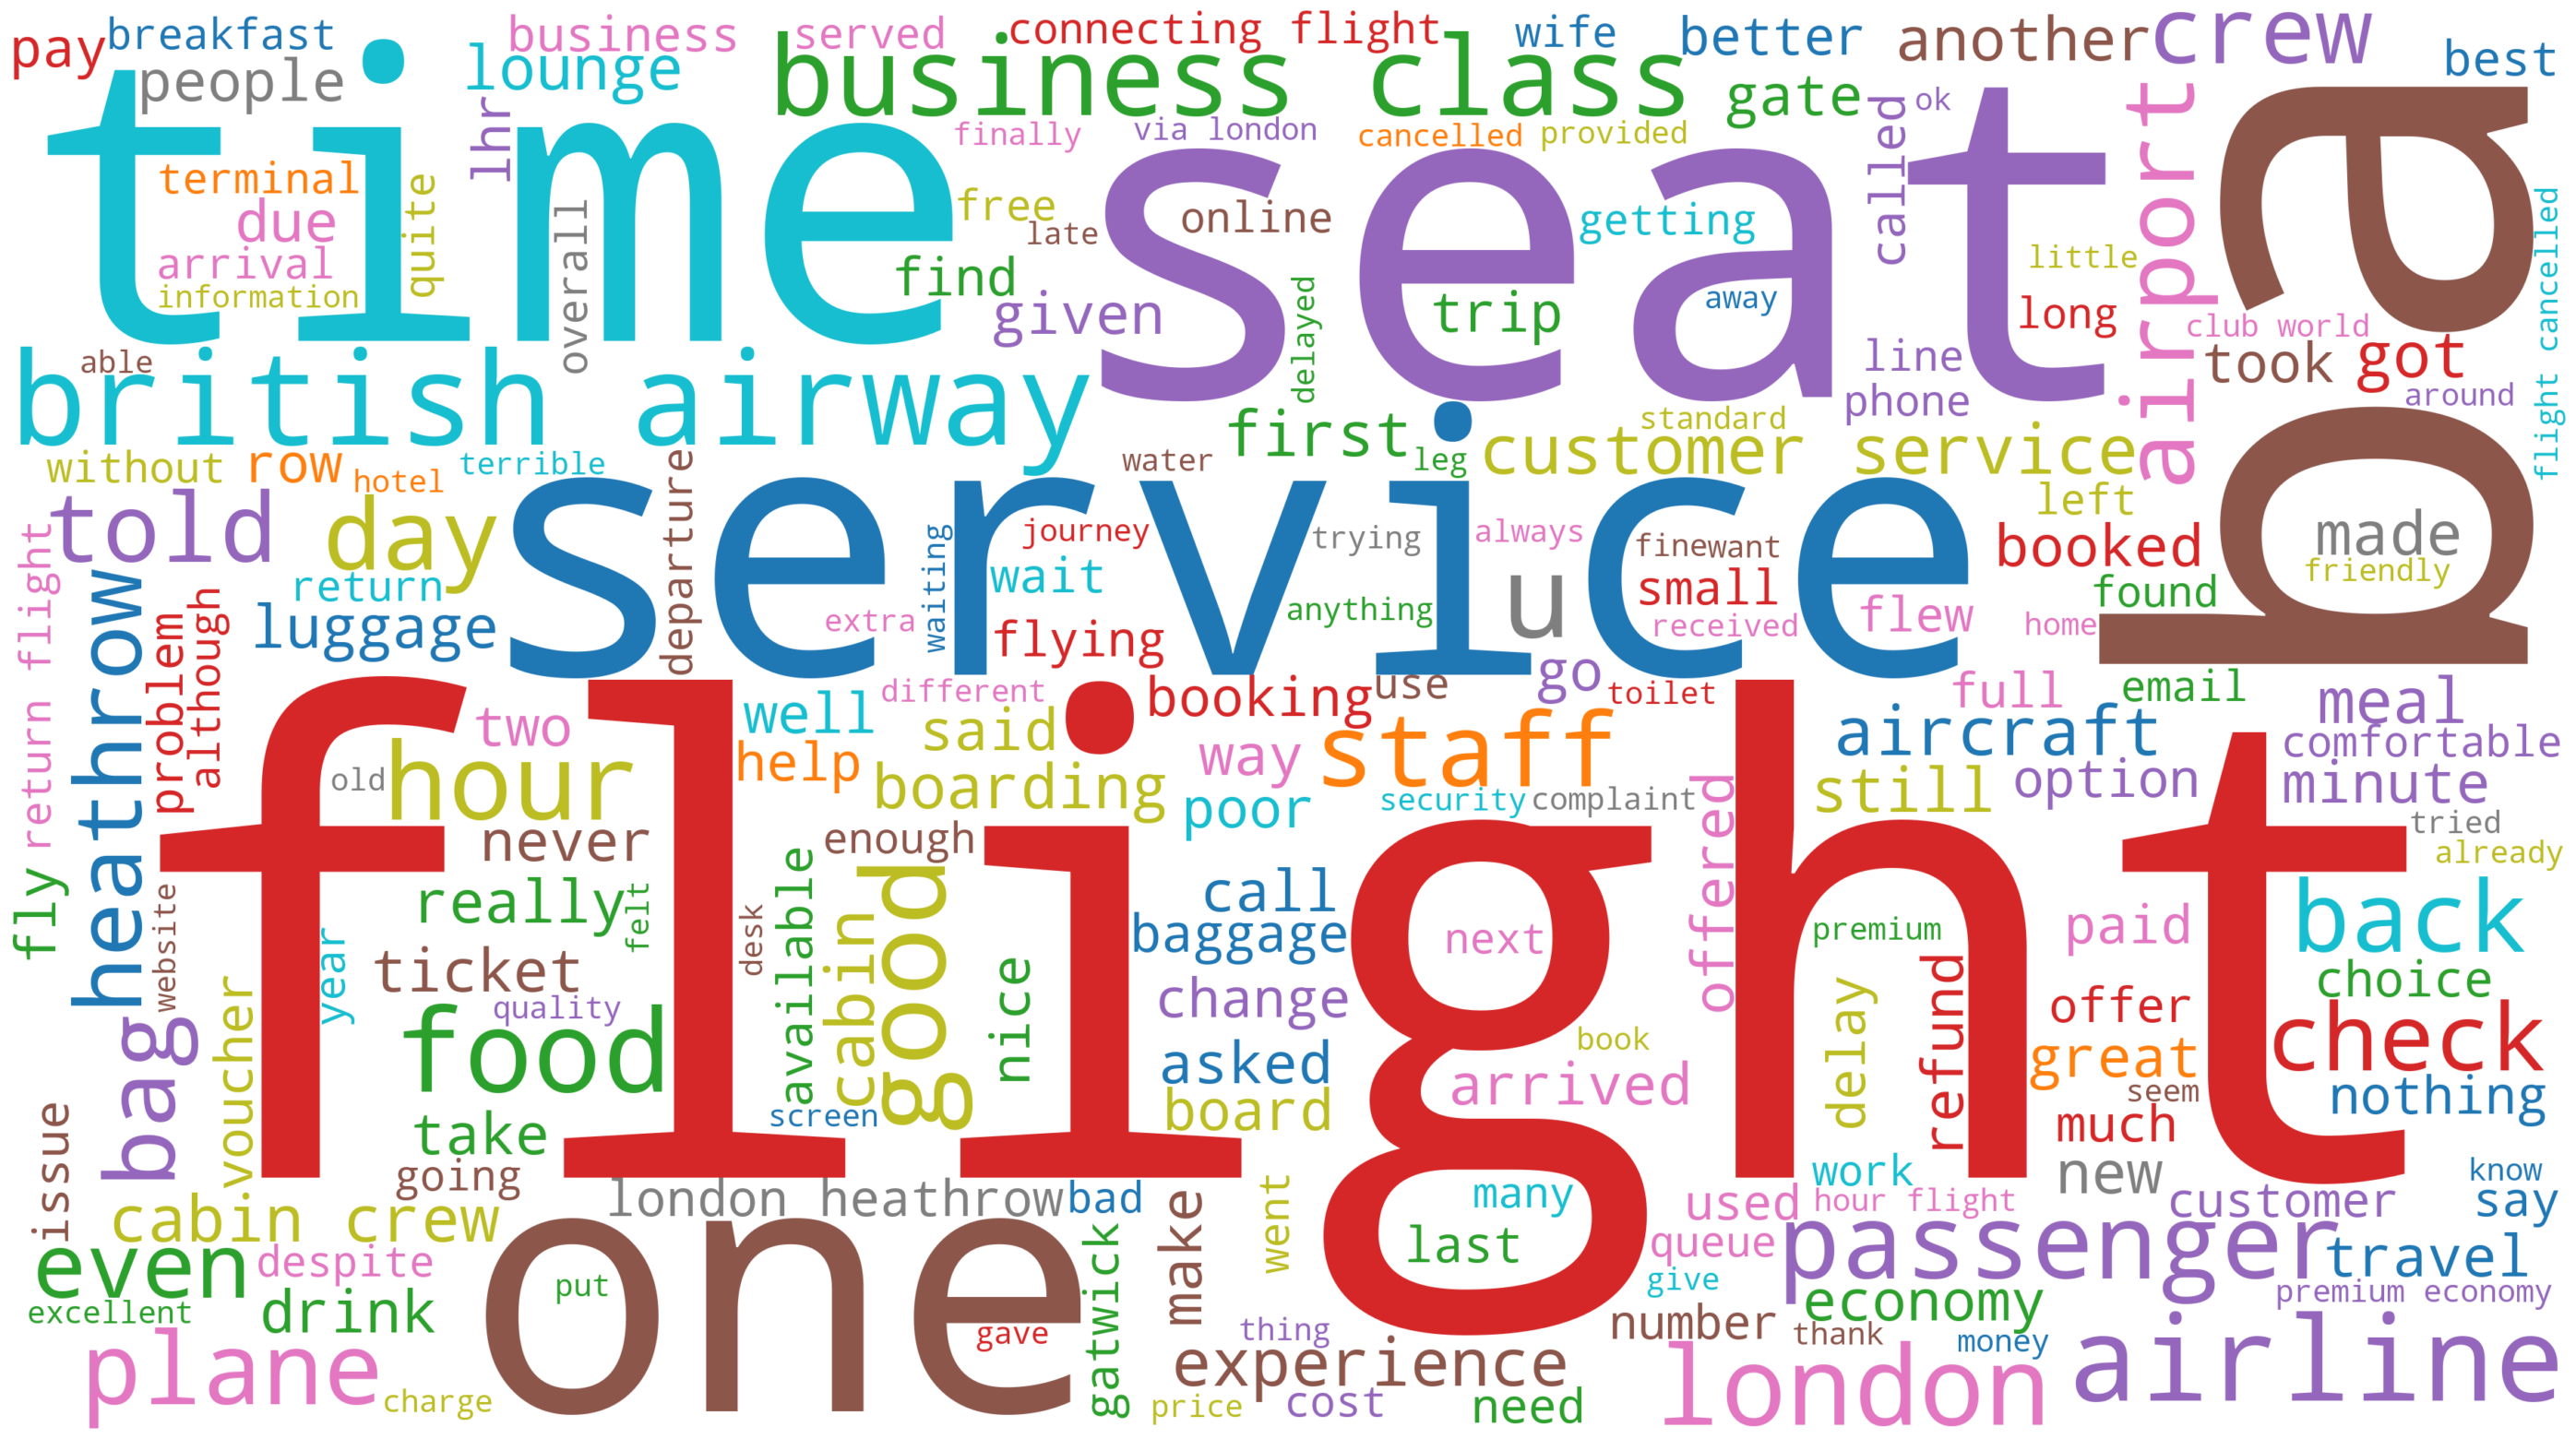

In [15]:
word_cloud = WordCloud(width =3600, height =2000, background_color='white', colormap='tab10')
word_cloud.generate(reviews_as_string)

plt.figure(figsize=[40,20])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Sentiment analysis with Vader and Text Blob

In [16]:
df['compound'] = [sid.polarity_scores(e)['compound'] for e in df['reviews']]
df['neg'] = [sid.polarity_scores(e)['neg'] for e in df['reviews']]
df['neu'] = [sid.polarity_scores(e)['neu'] for e in df['reviews']]
df['pos'] = [sid.polarity_scores(e)['pos'] for e in df['reviews']]

df['Vader sentiment']=0
df.loc[df['compound']>=0.05, 'Vader sentiment'] = 'Positive' #  genral metrix of measuring the sentiment of the text
df.loc[(df['compound']> -0.05) & (df['compound']<0.05), 'Vader sentiment'] = 'Neutral'
df.loc[df['compound']<=-0.05, 'Vader sentiment'] = 'Negative'

In [17]:
df.head()

,Unnamed: 0,reviews,compound,neg,neu,pos,Vader sentiment
0,0,downgraded business premium economy took three...,-0.9307,0.282,0.565,0.152,Negative
1,1,already delayed aircraft landed apart small ba...,-0.9012,0.167,0.770,0.063,Negative
2,2,caught gatwick cancellation fiasco point smoot...,0.3400,0.126,0.719,0.154,Positive
3,3,ba real problem boarding flight get first fill...,-0.7783,0.170,0.830,0.000,Negative
4,4,connecting flight london glasgow canceled forc...,-0.4588,0.115,0.885,0.000,Negative


In [18]:
vader = df['Vader sentiment'].value_counts()
print(vader)

Positive    571
Negative    408
Neutral      21
Name: Vader sentiment, dtype: int64


<AxesSubplot:ylabel='Vader sentiment'>

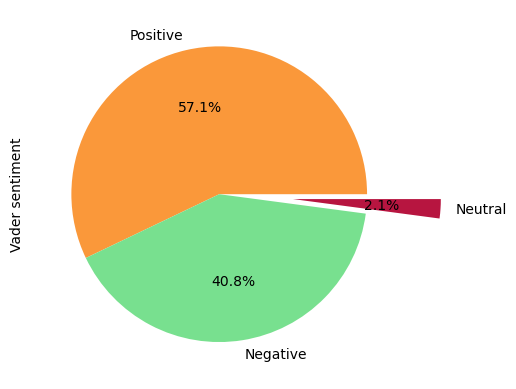

In [19]:
custom_colours = ['#fa983a','#78e08f', '#b71540']
vader.plot.pie(autopct="%.1f%%", colors=custom_colours, explode = (0,0, 0.5))

In [20]:
review_blob = [TextBlob(essay) for essay in df['reviews']]

df['Polarity'] = [b.sentiment.polarity for b in review_blob]
df['Subjectivity'] = [b.sentiment.subjectivity for b in review_blob]

df['TextBlob sentiment']=0
df.loc[df['Polarity']> 0, 'TextBlob sentiment'] = 'Positive'
df.loc[(df['Polarity'] == 0), 'TextBlob sentiment'] = 'Neutral'
df.loc[df['Polarity']< 0, 'TextBlob sentiment'] = 'Negative'


In [21]:
df.head()

,Unnamed: 0,reviews,compound,neg,neu,pos,Vader sentiment,Polarity,Subjectivity,TextBlob sentiment
0,0,downgraded business premium economy took three...,-0.9307,0.282,0.565,0.152,Negative,-0.029762,0.499405,Negative
1,1,already delayed aircraft landed apart small ba...,-0.9012,0.167,0.770,0.063,Negative,-0.121032,0.529762,Negative
2,2,caught gatwick cancellation fiasco point smoot...,0.3400,0.126,0.719,0.154,Positive,-0.135937,0.412500,Negative
3,3,ba real problem boarding flight get first fill...,-0.7783,0.170,0.830,0.000,Negative,-0.066667,0.380556,Negative
4,4,connecting flight london glasgow canceled forc...,-0.4588,0.115,0.885,0.000,Negative,-0.112727,0.410909,Negative


In [22]:
text_blob = df['TextBlob sentiment'].value_counts()
print(text_blob)

Positive    636
Negative    349
Neutral      15
Name: TextBlob sentiment, dtype: int64


<AxesSubplot:ylabel='TextBlob sentiment'>

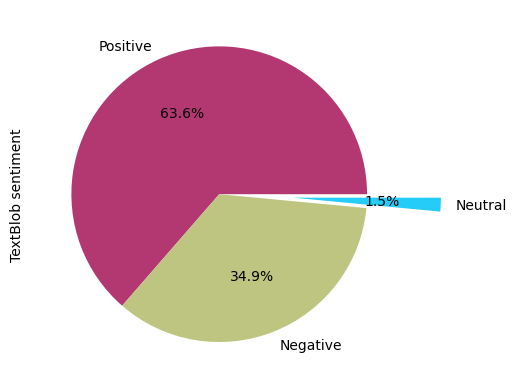

In [23]:
custom_colours = ['#B33771','#BDC581', '#25CCF7']
text_blob.plot.pie(autopct="%1.1f%%", colors=custom_colours, explode = (0,0, 0.5))